# Notebook to make Fig. 1

In [5]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import pandas as pd

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style

from helper_functions import *

style.use('plotting.mplstyle')

### Load data

In [6]:
f_root = '../Data/InjectedPopulationParameters/' 
pop1 = pd.read_json(f_root+'underlying_population1_highSpinPrecessing.json')
pop2 = pd.read_json(f_root+'underlying_population2_mediumSpin.json')
pop3 = pd.read_json(f_root+'underlying_population3_lowSpinAligned.json')

Condition into dict

In [7]:
spin_dict = {}

for i,pop in enumerate([pop1, pop2, pop3]):
    
    # spin magnitude
    chi1 = np.sqrt(pop.s1x**2 + pop.s1y**2 + pop.s1z**2)
    chi2 = np.sqrt(pop.s2x**2 + pop.s2y**2 + pop.s2z**2)
    chi = np.concatenate((chi1,chi2))
    
    # tilt angle
    cost1 = pop.s1z/chi1
    cost2 = pop.s2z/chi2
    cost = np.concatenate((cost1,cost2))
    
    # chi effective
    q = pop.m2/pop.m1
    chieff = calculate_chiEff(chi1, chi2, cost1, cost2, q)
    
    # chi p
    sint1 = np.sin(np.arccos(cost1))
    sint2 = np.sin(np.arccos(cost2))
    chip = calculate_chiP(chi1, chi2, sint1, sint2, q)

    spin_dict[f'pop{i+1}'] = {
        'chi':chi, 
        'cost':cost, 
        'chieff':chieff, 
        'chip':chip
    }

### Plot spin parameters for each population

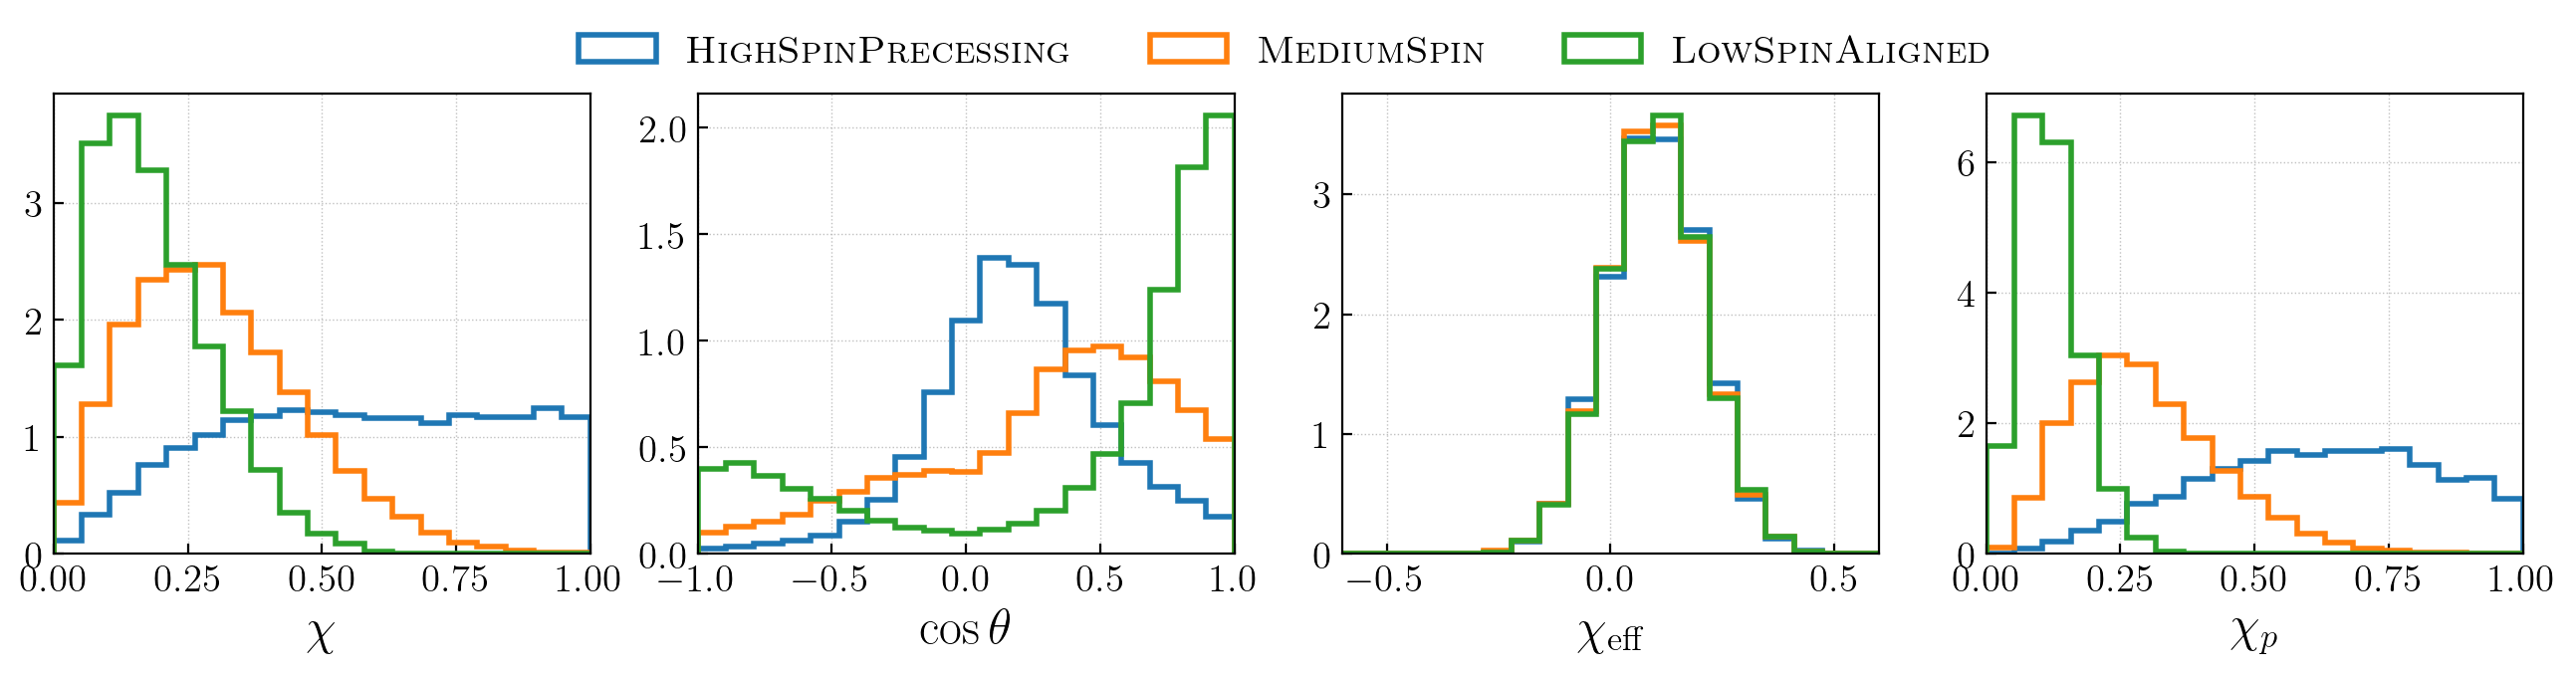

In [8]:
labels = [r'$\mathrm{\textsc{HighSpinPrecessing}}$', r'$\mathrm{\textsc{MediumSpin}}$', r'$\mathrm{\textsc{LowSpinAligned}}$']

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for i,pop in enumerate([pop1, pop2, pop3]):
    
    # spin magnitude
    axes[0].hist(spin_dict[f'pop{i+1}']['chi'], density=True, bins=np.linspace(0, 1, 20), histtype='step', lw=2, label=labels[i])
    axes[0].set_xlim(0,1)
    
    # tilt angle
    axes[1].hist(spin_dict[f'pop{i+1}']['cost'], density=True, bins=np.linspace(-1, 1, 20), histtype='step', lw=2)
    axes[1].set_xlim(-1,1)
    
    # chi effective
    axes[2].hist(spin_dict[f'pop{i+1}']['chieff'], density=True, bins=np.linspace(-0.6, 0.6, 20), histtype='step', lw=2)
    axes[2].set_xlim(-0.6,0.6)
    
    # chi p
    axes[3].hist(spin_dict[f'pop{i+1}']['chip'], density=True, bins=np.linspace(0, 1, 20), histtype='step', lw=2)
    axes[3].set_xlim(0, 1)
    
axes[0].legend(bbox_to_anchor=(0.95, 1.02, 1., .102), loc='lower left',
                      ncol=3,  borderaxespad=0.)
    
axes[0].set_xlabel(r'$\chi$')
axes[1].set_xlabel(r'$\cos\theta$')
axes[2].set_xlabel(r'$\chi_\mathrm{eff}$')
axes[3].set_xlabel(r'$\chi_p$')  

for ax in axes: 
    ax.grid(ls=':', color='silver', lw=0.5)
    
plt.savefig('figure_01.pdf',bbox_inches='tight')
plt.show()

### Calculate relevant quantities for the distributions

In [9]:
sys.path.append('./../Code/PopulationInference')
from posterior_helper_functions import calculate_Gaussian_1D
from scipy.stats import gaussian_kde

Mean and std. dev. for $\chi_\mathrm{eff}$

chieff mean: 0.09968248649965862
chieff std. dev.: 0.10700709627285304


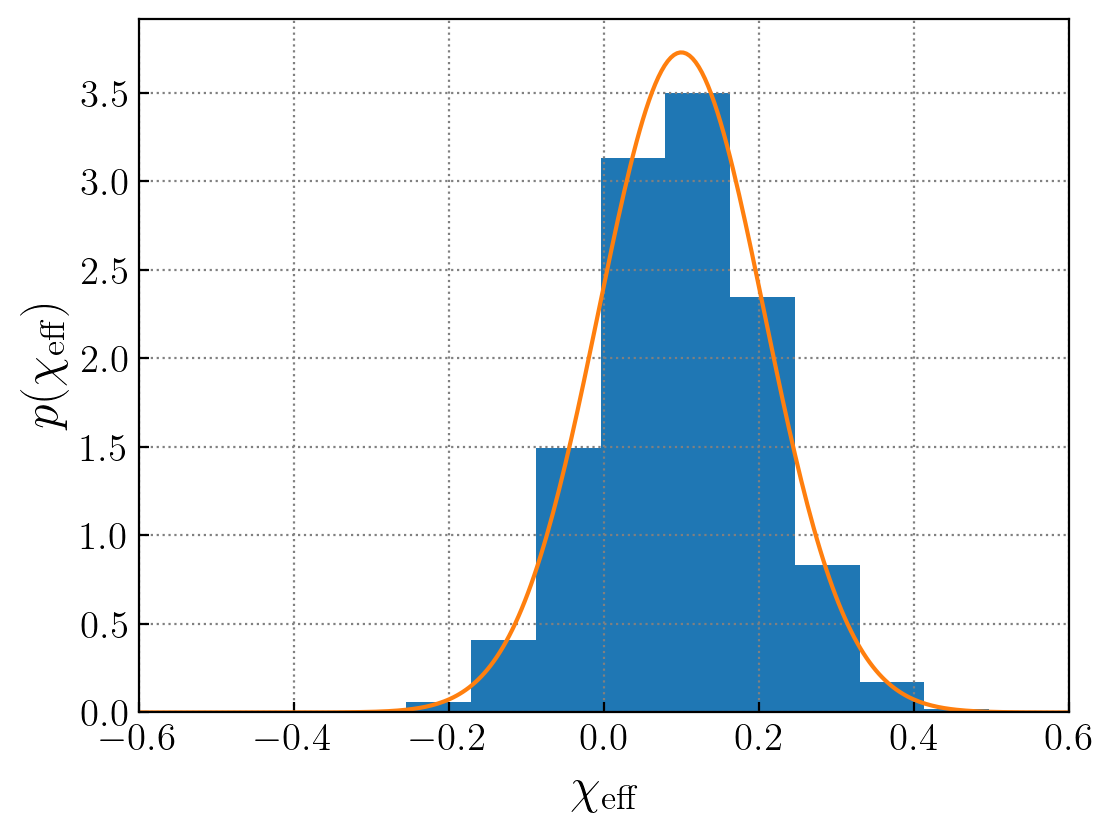

In [11]:
all_chieffs = np.concatenate([spin_dict[f'pop{i+1}']['chieff'] for i in range(2)])
print('chieff mean:', np.mean(all_chieffs))
print('chieff std. dev.:', np.std(all_chieffs))

chieff_grid = np.linspace(-1, 1, 500)
plt.figure()
plt.hist(all_chieffs, density=True)
plt.plot(chieff_grid, calculate_Gaussian_1D(chieff_grid, np.mean(all_chieffs), np.std(all_chieffs), -1, 1))
plt.xlabel(r'$\chi_\mathrm{eff}$')
plt.ylabel(r'$p(\chi_\mathrm{eff})$')
plt.xlim(-0.6, 0.6)
plt.show()

Peaks for $\chi$ for MediumSpin and LowSpinAligned populations

pop 2: peak is at chi = 0.27227227227227224
pop 3: peak is at chi = 0.1111111111111111


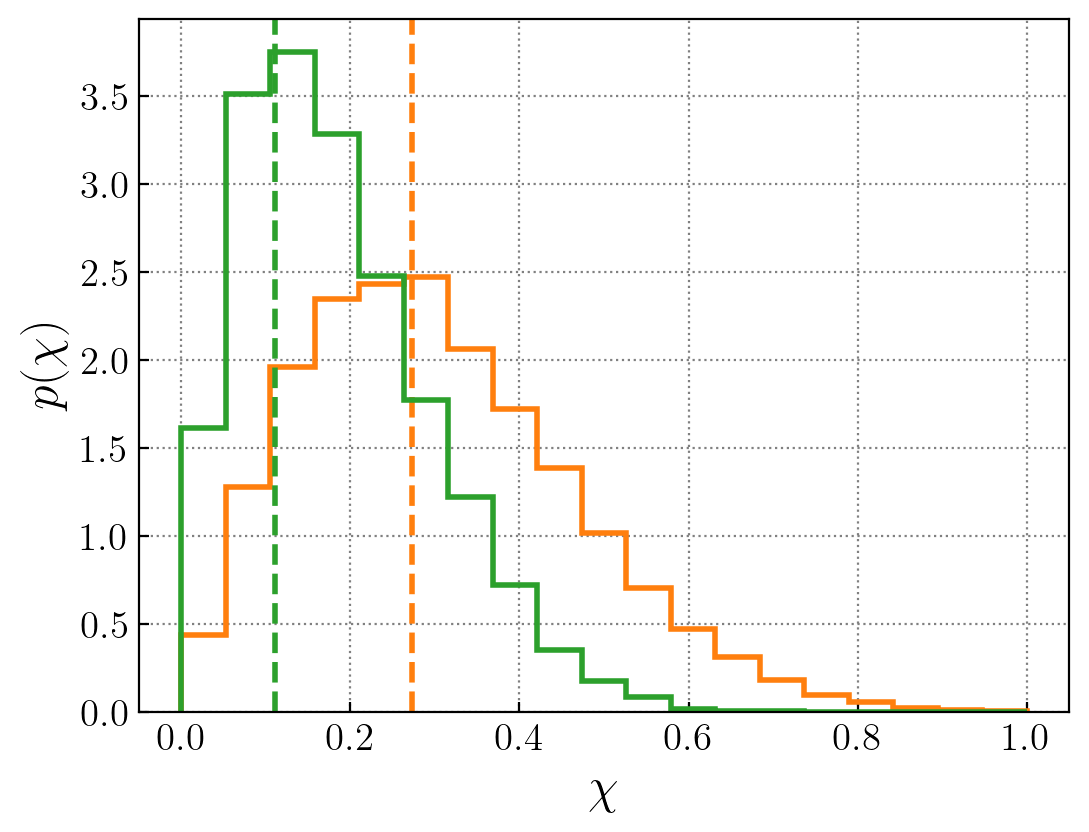

In [12]:
chi_grid = np.linspace(0,1,1000)

plt.figure()

for i in [2,3]: 
    
    chi = spin_dict[f'pop{i}']['chi']
    chi_kde = gaussian_kde(chi)(chi_grid) + gaussian_kde(2-chi)(chi_grid) + gaussian_kde(-chi)(chi_grid)
    
    peak_idx = np.argmax(chi_kde)
    peak = chi_grid[peak_idx]
    
    print(f'pop {i}: peak is at chi = {peak}')

    plt.hist(chi, density=True, color=f'C{i-1}',bins=np.linspace(0, 1, 20), histtype='step', lw=2, )
    plt.axvline(peak, color=f'C{i-1}', ls='--', lw=2)
    
plt.xlabel(r'$\chi$')
plt.ylabel(r'$p(\chi)$')
plt.show()